# Experimental Variogram
#### Mickey MacKie, Stanford Radio Glaciology

In this notebook, we compute the experimental variogram for a sample area in Greenland to quantify the topographic spatial relationships. Variograms are useful for examining spatial continuity, performing kriging interpolations, and generating stochastic realizations.

In [1]:
# load dependencies
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
  
import geostatspy.geostats as geostats 

## Load and plot data

Load in bed topography measurements from a 60 x 60 km$^2$ sample area covering part of Nioghalvfjerdsfjorden in Greenland. We use radar bed picks from CReSIS and exposed topography from BedMachine Greenland. The coordinates are polar stereographic coordinates.

In [2]:
df_bed = pd.read_csv('Data/Nioghalvfjerds_bed_data.csv') # download data
df_bed.head() # display data

,X,Y,Bed
0,461890.0,-1047400.0,-171.94
1,461820.0,-1047400.0,-178.19
2,461750.0,-1047500.0,-176.95
3,461680.0,-1047600.0,-178.70
4,461640.0,-1047600.0,-185.96


In [3]:
print('The data length is ' +  str(len(df_bed)))

The data length is 104292


<function matplotlib.pyplot.show(*args, **kw)>

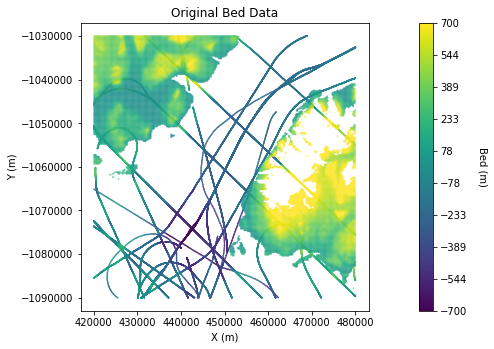

In [4]:
# plot original data
im = plt.scatter(df_bed['X'],df_bed['Y'], c = df_bed['Bed'], vmin = -700, vmax = 700, marker=".", s = 0.5) # scatter plot for location map
plt.title('Original Bed Data')                                    # add plot title
plt.xlabel('X (m)'); plt.ylabel('Y (m)')                          # set axis labels
cbar = plt.colorbar(im, orientation="vertical", ticks=np.linspace(-700, 700, 10)) # add vertical color bar
cbar.set_label("Bed (m)", rotation=270, labelpad=20)      # add labels to the color bar
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0) # adjust the plot size
plt.axis('scaled')
plt.show

Clearly there are some erroneous measurements here. We will deal with outliers and measurement uncertainty in a later script.

## Compute normal score transformation

Many geostatistical methods require Gaussian assumptions, so we need to perform a normal score transformation to convert to a standard Gaussian distribution (mean = 0, standard deviaton = 1, Gaussian shape). After performing a geostatistical analysis such as kriging, the data is back-transformed to it's original distribution.

In [5]:
# normal score transformation
df_bed['Nbed'], tvbed, tnsbed = geostats.nscore(df_bed,'Bed') 

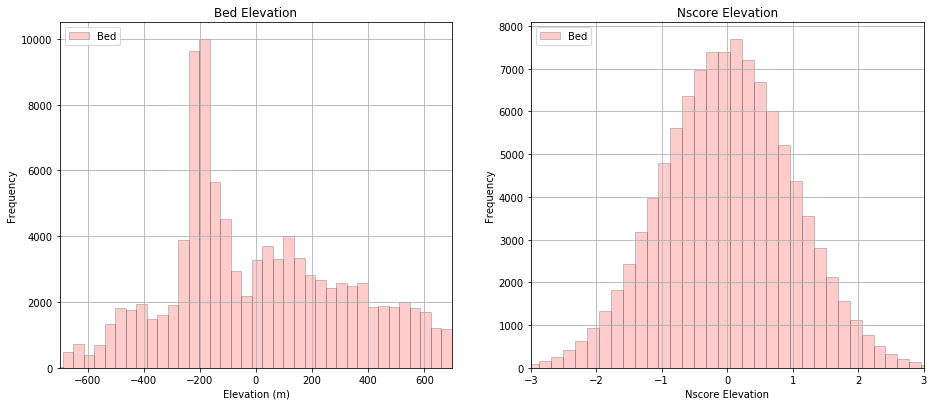

In [6]:
plt.subplot(121)                                        # plot original bed histogram
plt.hist(df_bed['Bed'], facecolor='red',bins=50,alpha=0.2,edgecolor='black',label='Bed')
plt.xlim([-700,700]); 
plt.xlabel('Elevation (m)'); plt.ylabel('Frequency'); plt.title('Bed Elevation')
plt.legend(loc='upper left')
plt.grid(True)

plt.subplot(122)                                        # plot normal score bed histogram (with weights)
plt.hist(df_bed['Nbed'], facecolor='red',bins=50,alpha=0.2,edgecolor='black',label='Bed')
plt.xlim([-3.0,3.0]); 
plt.xlabel('Nscore Elevation'); plt.ylabel('Frequency'); plt.title('Nscore Elevation')
plt.legend(loc='upper left')
plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.3)
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

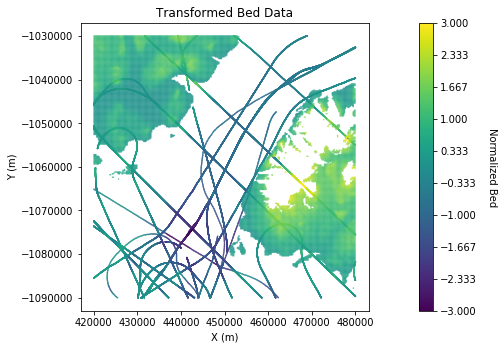

In [7]:
# plot transformed data
im = plt.scatter(df_bed['X'],df_bed['Y'], c = df_bed['Nbed'], vmin = -3, vmax = 3, marker=".", s = 0.5)       # scatter plot for location map
plt.title('Transformed Bed Data')                                    # add plot title
plt.xlabel('X (m)'); plt.ylabel('Y (m)')                          # set axis labels
cbar = plt.colorbar(im, orientation="vertical", ticks=np.linspace(-3, 3, 10)) # add vertical color bar
cbar.set_label("Normalized Bed", rotation=270, labelpad=20)      # add labels to the color bar
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0) # adjust the plot size
plt.axis('scaled')
plt.show

## Compute Experimental Variogram

The semivariogram, often just referred to as the variogram, is used to qauntify spatial dependence for irregularly spaced data. It computes the average variance of the difference between two data points with a given separation distance, or lag distance $\bf{h}$.

$$
\gamma(\bf{h}) = \frac{1}{2 N(\bf{h})} \sum^{N}_{\alpha=1} (Z(\bf{x}_\alpha) - Z(\bf{x}_\alpha + \bf{h}))^2  
$$


where $\bf{x}$ is a spatial location, $\bf{Z(x)}$ is a variable (e.g. bed elevation), and $\bf{N}$ is the number of lag distances. When calculating the variogram, you need to define the number of lag distances and lag spacing to use. You also need to set hyperparameters such as lag tolerance. For example, if lag distances are spaced at 1000 m intervals with a lag tolerance of 100 m, data points with a separation distance of 1100 m would be included in the average variance calculation at a 1000 m lag.

We'll start by computing the isotropic variogram, which averages across different azimuthal directions using the GeostatsPy tools. Because ice sheet datasets are extremely large, it can take a long time to calculate the variogram. Therefore, we will randomly downsample the data.

In [8]:
# randomly downsample data to 10% of the original size
df_samp = df_bed.sample(frac=0.10, replace=True, random_state=1)
print('Number of data points in random sample:' + str(len(df_samp)))

Number of data points in random sample:10429


In [9]:
# compute isotropic variogram
tmin = -9999.; tmax = 9999.;  # limits
lag_dist = 2000.0 # lag distance interval (in meters)
lag_tol = 100.0 # lag tolerance
nlag = 20 # number of lag distances to use
bandh = 9999.9 # no effect for isotropic variogram
azi = 0 # azimuth
atol = 90.0 # azimuth tolerance. If atol = 90, the isotropic variogram is calculated
isill = 1 # no effect for normal score transformed data

# variogram
lag, bed_gamma, bed_npair = geostats.gamv(df_samp,"X","Y","Nbed",tmin,tmax,lag_dist,lag_tol,nlag,azi,atol,bandh,isill)

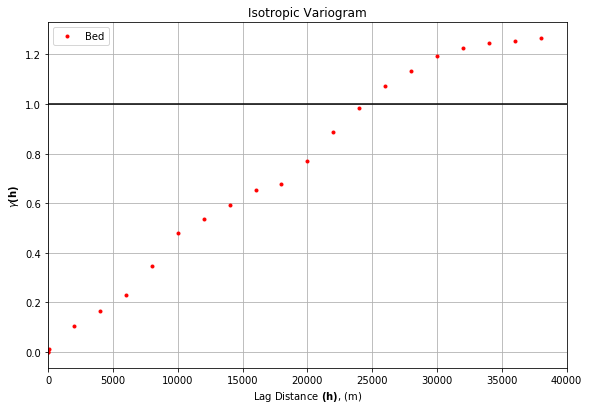

In [10]:
# plot variogram
plt.plot(lag,bed_gamma,'.',color = 'red',label = 'Bed')
plt.plot([0,40000],[1.0,1.0],color = 'black')
plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
plt.ylabel(r'$\gamma \bf(h)$')
plt.title('Isotropic Variogram')
plt.legend(loc='upper left')
plt.xlim([0,40000])
plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.2, top=1.2, wspace=0.1, hspace=0.2) # adjust the plot size
plt.show()

This plot shows the expected variance between two points as a function of lag distance. So for a lag distance of approximately zero, the variogram is close to zero because two points in the same location should not have much variability. The curve should start leveling out at $\gamma(\bf{h}) = 1$ because our data has undergone a normal score transformation.

Glacial topography is often highly anisotropic. So let's try calculating the variogram for different azimuthal directions.

In [11]:
# compute anisotropic variogram
bandh = 50 # bandwidth tolerance
azi_mat = [0,22.5,45,67.5,90,112.5,135,157.5]           # directions in azimuth to consider
atol = 10 # 10 degree tolerance

# Arrays to store the results
lag = np.zeros((len(azi_mat),nlag+2)); gamma = np.zeros((len(azi_mat),nlag+2)); npp = np.zeros((len(azi_mat),nlag+2));

# variogram
for iazi in range(0,len(azi_mat)):  # Loop over all directions to get variograms
    lag[iazi,:], gamma[iazi,:], npp[iazi,:] = geostats.gamv(df_samp,"X","Y","Nbed",tmin,tmax,lag_dist,lag_tol,nlag,azi_mat[iazi],atol,bandh,isill)
    

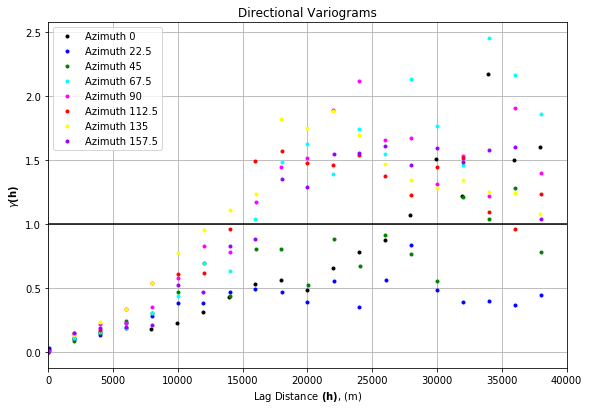

In [12]:
# plot anistropic variograms
plt.plot(lag[0,:],gamma[0,:],'.',color = 'black',label = 'Azimuth 0')
plt.plot(lag[1,:],gamma[1,:],'.',color = 'blue',label = 'Azimuth 22.5')
plt.plot(lag[2,:],gamma[2,:],'.',color = 'green',label = 'Azimuth 45')
plt.plot(lag[3,:],gamma[3,:],'.',color = 'cyan',label = 'Azimuth 67.5')
plt.plot(lag[4,:],gamma[4,:],'.',color = 'magenta',label = 'Azimuth 90')
plt.plot(lag[5,:],gamma[5,:],'.',color = 'red',label = 'Azimuth 112.5')
plt.plot(lag[6,:],gamma[6,:],'.',color = 'yellow',label = 'Azimuth 135')
plt.plot(lag[7,:],gamma[7,:],'.',color = '#9900ff',label = 'Azimuth 157.5')
plt.plot([0,40000],[1.0,1.0],color = 'black')
plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
plt.ylabel(r'$\gamma \bf(h)$')
plt.title('Directional Variograms')
plt.xlim([0,40000])
plt.legend(loc='upper left')
plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.2, top=1.2, wspace=0.1, hspace=0.2) # adjust the plot size
plt.show()

This shows us how the spatial dependencies vary in different directions. We can clearly observe anisotropy in the data. For example, the variance is lowest at an azimuth of approximately 22.5 from vertical, which corresponds roughly with ice flow direction. This makes sense because topography is often smoother along ice flow direction.